<a href="https://colab.research.google.com/github/takotab/gas-predictor/blob/seq-fastai/notebooks/_v2_seq_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu92/torchvision-0.4.2%2Bcu92-cp36-cp36m-linux_x86_64.whl
ERROR: torchvision 0.4.2+cu92 has requirement torch==1.3.1, but you'll have torch 1.0.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/site-packages/torchvision-0.4.2+cu92.dist-info'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# !pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-dx1n5c3j
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-dx1n5c3j
  Created wheel for fastai2: filename=fastai2-0.0.1-cp37-none-any.whl size=166431 sha256=8465893112c879e8d25dd04941f22a31460611fb619ed4fccbd0e04ed58ea190
  Stored in directory: /tmp/pip-ephem-wheel-cache-udjueqs1/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import os
import sys
# sys.path.append('..')
# from pathlib import Path
import pandas as pd
import datetime as dt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
from fastai2.test import *
from fastai2.core import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.text.core import *
from fastai2.text.data import *
from fastai2.text.models.core import *
from fastai2.text.models.awdlstm import *
from fastai2.callback.rnn import *
from fastai2.callback.all import *

In [6]:
def plot_days(data, ax=None, left=None, right=None, figsize = None,title=None, spacing=.1,  **kwargs):
    from pandas import plotting
    figsize = ifnone(figsize,(20,10))
    if ax is None: _,ax = plt.subplots(figsize=figsize)           
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(left)+len(right))
    for c in left+right:
        if c not in data:
            print(f'Warning{c} not in {data.columns}')
    # First axis
    ax = data.loc[:, left].plot(label=left, color=colors[:len(left)],ax = ax, **kwargs)
    ax.set_ylabel(ylabel=left)
    lines, labels = ax.get_legend_handles_labels()

    for n in range(len(right)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, right[n]].plot(ax=ax_new, label=right[n], color=colors[len(left)+n % len(colors)],**kwargs)
        ax_new.set_ylabel(ylabel=right[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    if title is not None: ax.set_title(title)
    return ax

In [497]:
from copy import copy 
class Days(CollBase, GetAttr, FilteredBase):
    def __init__(self,df, y_names, cat_var, con_var):
        self.cat_var, self.con_var, self.y_names = cat_var, con_var, y_names                    
        self.df = df
        self.df.set_index('datetime',drop=False,inplace=True)  
        self.cols = ['datetime']+self.con_var+self.cat_var
        for c in self.cols+self.y_names:
            if c not in self.df.columns:
                print(f'Warning {c} not in {self.df.columns}')
    def __repr__(self):
        return str(self.df)
    
    def copy(self):
        return copy(self)
    
    def repr(self):
        return {'y_names':self.y_names,'cat_var':self.cat_var,'con_var': self.con_var }
    
    def show(self,plot=True,**kwargs):
        title= f"{self.df['loc'][0]} ({self.df['city'][0]}) from {str(min(self.df.loc[:,'datetime']))} to {str(max(self.df.loc[:,'datetime']))} #{self.df.shape[0]}"

        if plot:
            plot_days(self.df,left=self.y_names+['pred'],right=self.con_var,title=title,**kwargs)
        else:
            return title+'\n'+str(self.df.head(1)   ) 
            
    @classmethod
    def from_intervals(cls,intervals,seq_len,y_names, cat_var, con_var):
        
        cls(_df, y_names, cat_var, con_var)
    

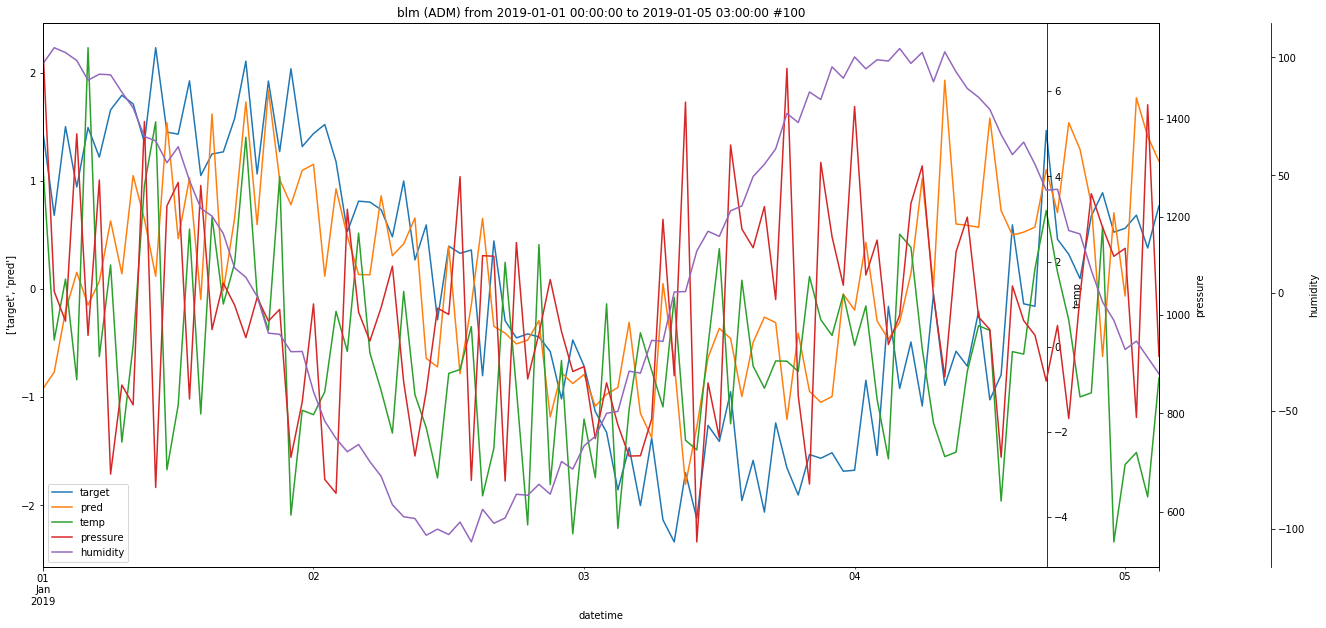

In [498]:
def make_fake_data(num, l=None, locations = 4, jumps = True, chance_of_jump = 0.9):
    locs,citys  =['blm','cnt','rzb','ctl'],['ADM','ADM','ADM','RTD']
    dfs = []
    for i_loc in range(locations):
        loc,city = locs[i_loc], citys[i_loc]
        start = pd.Timestamp('2019-01-01')
        for i in range(num):
            l = ifnone(l,100)
            t = i+np.arange(l)/12
            _df = pd.DataFrame(data={'datetime':[start+pd.Timedelta(hours=x) for x in range(l)],
                                'target':np.random.randn(l)*.5+np.sin(t)+np.cos(t/2), 
                                'pred':np.random.randn(l)*.5+np.sin(t),                                        
                                'temp':np.random.randn(l)*2+np.cos(t)+np.cos(-t/2),
                                'pressure':1000+100*(np.random.randn(l)*2+np.cos(-t)),
                                'humidity':np.random.randn(l)*5+np.cos(t)*100,
                                'loc':[loc]*l,
                                'city':[city]*l})
            dfs.append(_df)
            start += pd.Timedelta(hours=l)
            if np.random.rand()> chance_of_jump and jumps:
                start += pd.Timedelta(hours=l*3)   
                start+=(pd.Timedelta('1H')*np.random.choice(np.arange(24)))
    return pd.concat(dfs)
_df = make_fake_data(1,locations=1)
it = Days(_df,['target'],['loc','city'],['temp','pressure','humidity'])
it.show(figsize=(20,10))

In [499]:
df = make_fake_data(100,locations=4)
print(df.shape, min(df.datetime),max(df.datetime))
df.head()

(40000, 8) 2019-01-01 00:00:00 2020-08-21 07:00:00


,datetime,target,pred,temp,pressure,humidity,loc,city
0,2019-01-01 00:00:00,0.457203,-0.646789,3.672105,1043.653446,105.164236,blm,ADM
1,2019-01-01 01:00:00,1.188633,-0.156254,5.313274,1193.499629,101.869251,blm,ADM
2,2019-01-01 02:00:00,0.474366,-0.115797,0.324744,1206.492871,103.809502,blm,ADM
3,2019-01-01 03:00:00,0.720727,0.695284,2.765001,1133.342520,99.285244,blm,ADM
4,2019-01-01 04:00:00,1.319508,-0.647158,4.179592,1224.751492,92.496095,blm,ADM


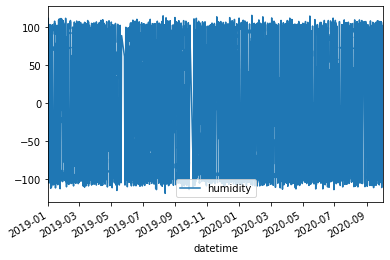

In [500]:
df = make_fake_data(100,locations=2,l=120,jumps=True)
df.index = df.datetime
df[['humidity']].plot()

In [501]:
from copy import copy
def to_elapsed(s):
    return s.astype(np.int64) // 10 ** 9

def remove_last(df,start, end, sz):
    old_start = copy(start)
    start = end - sz + pd.Timedelta(hours = 1)
    return df[start:end], old_start, start
    
def get_not_interval(df, interval, shift = 1):
    df.index = df.datetime
    df = df.sort_index()
    df["delta"] = abs(
        (to_elapsed(df["datetime"]) - to_elapsed(df["datetime"].shift(shift)))
    )
    #     df["delta"] = df['delta'].dt.seconds
    not_hour = df.index[df["delta"] != interval].tolist()
    del df["delta"]
    return not_hour
    

def make_interval(
    df: pd.DataFrame,
    interval=3600,
    sz='72H',
    max_splits=35,
    callback_error=None,
) -> pd.DataFrame:
    """Will check if `df.datetime` has interval of `interval` in seconds. 
    
    if not will make it happen and return a list where this is done.
    """
    starts = get_not_interval(df, interval, 1)
    ends = get_not_interval(df, interval, -1)
    dfs = []
    for start, end in zip(starts,ends):        
        dfs += [df.loc[i:i+pd.Timedelta(sz),:] for i in pd.date_range(start,end,freq=sz) ]       

    return dfs

dfs = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    dfs += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
lengths =pd.DataFrame({'rows':[dfs[i].df.shape[0] for i in range(len(dfs))]})

In [502]:
pd.value_counts(lengths['rows'])

73    320
72      9
24      9
48      2
Name: rows, dtype: int64

In [503]:
df = make_fake_data(100,locations=4,l=100,jumps=True)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
    

In [504]:
print('\n'.join([d.show(plot=False) for d in items[[0,-1]][::-1]]))

ctl (RTD) from 2020-06-17 08:00:00 to 2020-06-18 19:00:00 #36
                               datetime    target      pred      temp  \
datetime                                                                
2020-06-17 08:00:00 2020-06-17 08:00:00 -1.295215 -0.603116 -0.874705   

                       pressure   humidity  loc city  
datetime                                              
2020-06-17 08:00:00  675.067814 -83.233844  ctl  RTD  
rzb (ADM) from 2019-01-01 00:00:00 to 2019-01-04 00:00:00 #73
             datetime    target      pred      temp     pressure  humidity  \
datetime                                                                     
2019-01-01 2019-01-01  0.654618 -0.065118  2.816921  1054.948532  97.74452   

            loc city  
datetime              
2019-01-01  rzb  ADM  


In [505]:
def split_idxs(items):
    total = 0
    train_idx, valid_idx, test_idx = [], [], []
    train_idx_s, valid_idx_s, test_idx_s = 0,0,0
    for idx, it in enumerate(items):
        
        ts = it.df['datetime'].iloc[0]
        total += _df.shape[0]
        if  ts.month == 2       :
            if ts.minute == 0:
                test_idx.append(idx)
                test_idx_s += _df.shape[0]

        elif ts.month == 9 or ts.month == 10:
            if ts.minute == 0:
                valid_idx.append(idx)
                valid_idx_s += _df.shape[0]
        else:
            train_idx.append(idx)
            train_idx_s +=_df.shape[0]

    if len(valid_idx) == 0 and len(train_idx):
        valid_idx.append(train_idx.pop(-1))
    if len(test_idx) == 0 and len(train_idx):
        test_idx.append(train_idx.pop(-1))
    print()
    print("Test set length\t\t", test_idx_s / total, test_idx_s)
    print("Validation set length\t", valid_idx_s / total,valid_idx_s)
    print("Train set length\t", train_idx_s / total, train_idx_s)
    print(total, test_idx_s)
    
    return [train_idx, valid_idx, test_idx]

splits = split_idxs(items)


Test set length		 0.09342560553633218 540000
Validation set length	 0.08823529411764706 510000
Train set length	 0.8183391003460208 4730000
5780000 540000


In [506]:
def _to_elapsed(o:int):
    return o // 10 ** 9
def _to_dt(o):
    return o*(10**9)
pd.Timestamp(_to_dt(_to_elapsed(pd.Timestamp('2019-01-01').value)))

Timestamp('2019-01-01 00:00:00')

In [507]:
class Change_dt(Transform):
    def __init__(self, start=None, col='datetime'):
        self.start = ifnone(start, _to_elapsed(pd.Timestamp('2019-01-01').value))
        self.col = col
        
    def encodes(self, o:Days): 
        o.df[self.col] = _to_elapsed(o.df[self.col].astype(int)) - self.start
        return o
    
    def decodes(self, o:Days): 
        o.df[self.col] = pd.to_datetime(_to_dt(o.df[self.col] + self.start))
        o.df.index = o.df[self.col]
        return o

_df = make_fake_data(1,locations=1)
it = Days(_df, ['target'],['loc','city'],['temp','pressure','humidity'])
Dt = Change_dt()
it = Dt(it) 
_ = Dt.decodes(it)

In [508]:
test_eq(it.df, Dt.decode(Dt(it)).df)

In [509]:
class TensorSequenceX(TensorBase):pass
class Numericalize(Transform):
    "Reversible transform of tokenized cat_var to numericalized ids"
    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        self.vocab,self.o2i = {},{}
        for cat in self.item.cat_var:
            count = L()
            for i in [list(o.df[cat].unique()) for o in dsrc]:
                count.append(*i)
            self.o2i[cat] = {k:i for i,k in enumerate(count.unique())}            
            self.vocab[cat] = {v:k for k,v in self.o2i[cat].items()}

    def encodes(self, o:Days): 
        for c in self.item.cat_var:
            o.df.loc[:,c] = o.df.loc[:,c].map(self.o2i[c])
        res = o.df.loc[:,self.item.cols].values
        return TensorSequenceX(tensor(res))
    
    def decodes(self, o:TensorSequenceX):         
        o = pd.DataFrame(o.numpy(),columns = self.item.cols )
        for c in self.item.cat_var:
            o[c] = o[c].map(self.vocab[c])
        return Days(o,**self.item.repr())
    
    def get_vocab_sz(self):
        return [len(self.vocab[v]) for v in self.item.cat_var]
    

In [510]:
df = make_fake_data(10,locations=3,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
num = Numericalize()
num.setup(items)
test_eq(len(num.vocab['loc']), len(set(df['loc'])))
test_eq(len(num.vocab['city']), len(set(df['city'])))
test_eq(num.get_vocab_sz(),(len(set(df['city'])), len(set(df['loc']))))

In [511]:
it = items[0].copy()
Dt = Change_dt()
_it = num(Dt(it))
df = Dt.decodes(num.decode(_it )).df
test_eq(df[it.cols],it.df[it.cols])

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'city', 'loc'], dtype='object')


In [512]:
class TensorSequenceY(TensorBase):pass

class Label(Transform):    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        
    def encodes(self, o:Days): 
        return TensorSequenceY(tensor(o.df[self.item.y_names].copy().values))
    
    def decodes(self, o:TensorSequenceY):         
        o = pd.DataFrame(o.numpy(),columns = self.item.y_names )
        return o
    

In [513]:
df = make_fake_data(10,locations=1,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
lab = Label()
lab.setup(items[:10])
test_eq(lab(items[1]).shape,(73,1))
test_eq(lab.decodes(lab(items[0])).shape, (73, 1))

In [514]:
class SeqLen(Transform):
    def __init__(self,len=73):
        self.len = len
        
    def encodes(self, o):   
        a = torch.zeros(self.len,o.shape[1])
        _len = min([self.len,o.shape[0]])
        a[:_len,:] = o[:_len,:]
        return a
    
    def decodes(self, o):
        return o
    

In [515]:
seqlen = SeqLen(73)
test_eq(seqlen(tensor(np.random.rand(50,3))).shape,(73,3))
test_eq(seqlen(tensor(np.random.rand(50,8))).shape,(73,8))

In [516]:
del seqlen
seqlen = SeqLen(10)
test_eq(seqlen(tensor(np.random.rand(50,3))).shape,(10,3))

In [734]:
class Normalize(Transform):   
    def __init__(self, norm_cols= None):
        self.norm_cols = norm_cols
        
    def setup(self, dsrc):
        if dsrc is None: return
        if self.norm_cols == None:
            self.norm_cols = range(dsrc[0].shape[-1])
        its = torch.cat([o[None,:,self.norm_cols] for o in dsrc])
        self.m,self.s = Tensor([0]*dsrc[0].shape[-1]),Tensor([1]*dsrc[0].shape[-1])
        self.m[self.norm_cols],self.s[self.norm_cols] = its.mean((0,1)),its.std((0,1))+1e-5
        
    def encodes(self, o):
        print(o[0,:],self.s)
        o = (o-self.m)/self.s
        print(o[0,-1])
        return o
        
    
    def decodes(self, o):         
        o= (o*self.s)+self.m
        return o
    

In [735]:
a = np.array([[1+np.arange(7)]*73]*100)*(1+.3*np.random.randn(100,73,7))
# a[:,:,6] = 3.14
print(a.shape)
b = Tensor(a)
(b.mean((0,1)),b.std((0,1)))

(100, 73, 7)


(tensor([0.9949, 1.9989, 2.9845, 4.0013, 4.9974, 6.0010, 6.9841]),
 tensor([0.2982, 0.5983, 0.9006, 1.2009, 1.4976, 1.7876, 2.1262]))

In [736]:
norm = Normalize(range(6))
its = Tensor()
norm.setup([Tensor(a[i]) for i in range(a.shape[0])])
print(norm.m,norm.s)
test_close(norm.m, Tensor([1,2,3,4,5,6,0]),0.1)
test_close(norm.s,Tensor([.3,.6,.9,1.2,1.5,1.8,1]),0.1)

tensor([0.9949, 1.9989, 2.9845, 4.0013, 4.9974, 6.0010, 0.0000]) tensor([0.2982, 0.5983, 0.9006, 1.2010, 1.4976, 1.7876, 1.0000])


In [737]:
res = norm(Tensor(a))
test_close(res.mean((0,1)),Tensor([0]*6 + [7]),0.1)
test_close(res.std((0,1)),Tensor([1]*6+[2.1]),0.1)

tensor([[ 0.7604,  1.9073,  3.2448,  4.1350,  3.2491,  2.9014,  8.7374],
        [ 1.0452,  3.2441,  3.6928,  5.4061,  5.7329,  3.7127,  7.8487],
        [ 1.2924,  1.7400,  3.8465,  4.2471,  5.8534,  5.9358,  6.2482],
        [ 0.7619,  2.3316,  3.9863,  4.8989,  2.6817,  7.5145,  5.1923],
        [ 0.9182,  2.7739,  2.5212,  3.0629,  5.3261,  8.8464,  8.9938],
        [ 0.3296,  1.3452,  2.6804,  4.8992,  4.9832,  7.4848, 10.8709],
        [ 0.8119,  1.9736,  2.5430,  3.5199,  7.4757,  6.7306,  8.6259],
        [ 1.1511,  1.2973,  4.7636,  3.6578,  3.2841,  4.8970,  6.5399],
        [ 0.8851,  1.8327,  4.7590,  4.8892,  3.9729,  4.9461,  5.2310],
        [ 0.9195,  1.6182,  4.0560,  4.8227,  3.6203,  3.0571,  9.0725],
        [ 1.0034,  1.6256,  2.3517,  3.8223,  4.2218,  8.2616, 10.7214],
        [ 1.0391,  2.4108,  4.2778,  4.8132,  4.5048,  6.3757,  6.0834],
        [ 1.0737,  1.7135,  3.6872,  2.9256,  4.6687,  6.2004,  7.5603],
        [ 1.0188,  1.7244,  2.7122,  3.6605,  3.076

In [738]:
a_res = norm.decodes(res)
test_close(a_res.mean((0,1)), Tensor([1,2,3,4,5,6,7]),0.1)
test_close(a_res.std((0,1)), Tensor([.3,.6,.9,1.2,1.5,1.8,2.1]),0.1)

In [739]:
df = make_fake_data(100,locations=4,l=140,jumps=True)

In [740]:
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))

In [741]:
splits = split_idxs(items)


Test set length		 0.11363636363636363 1260000
Validation set length	 0.1414141414141414 1568000
Train set length	 0.7449494949494949 8260000
11088000 1260000


In [742]:
import warnings
warnings.filterwarnings('ignore')

In [743]:
bs,sl = 16,73
dsrc = DataSource(items, [[Change_dt(), Numericalize(),SeqLen(sl), Normalize(range(4))],
                          [Label(), SeqLen(sl)]
                         ],
                  splits=splits)

In [744]:
dbch = dsrc.databunch(bs=bs, after_batch=[Cuda])
[o.shape for o in dbch.one_batch()]

tensor([-1.5463e+09,  5.8275e-01,  1.2113e+03,  7.1937e+00,         nan,
                nan]) tensor([2.2046e+08, 2.2090e+00, 2.5398e+02, 7.0105e+01, 1.0000e+00, 1.0000e+00])
tensor(nan)
tensor([-1.5463e+09, -2.3145e+00,  1.1676e+03,  1.7717e+01,         nan,
                nan]) tensor([2.2046e+08, 2.2090e+00, 2.5398e+02, 7.0105e+01, 1.0000e+00, 1.0000e+00])
tensor(nan)
tensor([-1.5463e+09,  3.5829e-01,  8.0472e+02,  7.8800e+01,         nan,
                nan]) tensor([2.2046e+08, 2.2090e+00, 2.5398e+02, 7.0105e+01, 1.0000e+00, 1.0000e+00])
tensor(nan)
tensor([-1.5463e+09,  7.1252e-01,  7.6301e+02, -9.0908e+01,         nan,
                nan]) tensor([2.2046e+08, 2.2090e+00, 2.5398e+02, 7.0105e+01, 1.0000e+00, 1.0000e+00])
tensor(nan)
tensor([-1.5463e+09, -1.2327e+00,  8.9318e+02, -8.5451e+01,         nan,
                nan]) tensor([2.2046e+08, 2.2090e+00, 2.5398e+02, 7.0105e+01, 1.0000e+00, 1.0000e+00])
tensor(nan)
tensor([-1.5463e+09,  9.8458e-02,  9.6039e+02,  5.7199e+01, 

[torch.Size([16, 73, 6]), torch.Size([16, 73, 1])]

In [ ]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

In [ ]:
print(dbch.tfms[0][1].vocab)
emb_sz = [(n,emb_sz_rule(n)) for n in dbch.tfms[0][1].get_vocab_sz()]
print(emb_sz)

In [ ]:
class LSTM(Module):
    initrange=0.1

    def __init__(self, emb_szs, n_in, n_hid, n_layers,n_out):
        store_attr(self, 'emb_szs,n_hid,n_layers')
        # not going to use embeddings for now
        # self.emb = [nn.Embedding(emb_sz[0], emb_sz[1]) for emb_sz in emb_szs ]
        self.bn = nn.BatchNorm1d(n_in)
        self.bn.bias.data.fill_(1e-3)
        self.bn.weight.data.fill_(1)
        self.bn2 = nn.BatchNorm1d(n_hid)
        self.b = nn.Parameter(Tensor([0]*n_in))
        self.w = nn.Parameter(Tensor([1]*n_in))
        input_sz = n_in #+ np.sum([emb_sz[0] for emb_sz in emb_szs ])
        self.rnn = nn.LSTM(input_sz, n_hid, n_layers-1, batch_first=True) 
        
        self.last_layer = nn.LSTM(n_hid, n_out, 1, batch_first=True)
        
    def forward(self, x):
        x = self.bn(x.transpose(1,2)).transpose(1,2)
        raw_output = x *self.w+self.b
        raw_output,_ = self.rnn(x) 
        raw_output = self.bn2(raw_output.transpose(1,2)).transpose(1,2)        
        o,_ = self.last_layer(raw_output)
        return o

mdl = LSTM(emb_sz, 6, 32, 2, 1).to(device)
b = dbch.one_batch()
out = mdl(b[0])
print(out.shape,b[1].shape,b[0])

In [610]:
learn = Learner(dbch, LSTM(emb_sz, 6, 8, 2, 1), loss_func=mse,cbs=ActivationStats(), opt_func=RAdam, metrics=[mae])

In [611]:
learn.lr_find()

AttributeError: 'tuple' object has no attribute 'float'

In [428]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,mae,time
0,0.890982,nan,nan,00:02


In [403]:
learn.validate()

(#2) [nan,nan]